In [7]:
#read data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
df = pd.read_csv("/Users/rakeshravi/Documents/Spring/Text Analytics/Project/corpus.csv", sep = "|")

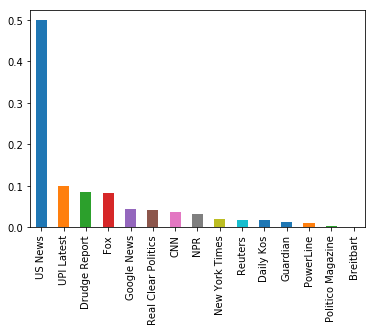

In [8]:
#what is distribution for sources
df.doc_source.value_counts(normalize = True).plot('bar')

In [9]:
#drop NaNs
df = df.dropna()
df.shape

(722410, 6)

In [10]:
# assigning labels of left leaning (L) and right leaning (R)
list_of_sources = ['US News', 'UPI Latest','Drudge Report','Fox',
'Google News',
'Real Clear Politics',
'CNN',
'NPR',
'New York Times',
'Reuters',
'Daily Kos',
'Guardian',
'PowerLine',
'Politico Magazine',
'Breitbart']

list_of_labels = ['left-center',
'center',
'right',
'right',
'left',
'right-center',
'left',
'left-center',
'left-center',
'center',
'left',
'left-center',
'right',
'center',
'right']

dictionary = dict(zip(list_of_sources, list_of_labels))
df['label']= df['doc_source'].map(dictionary)

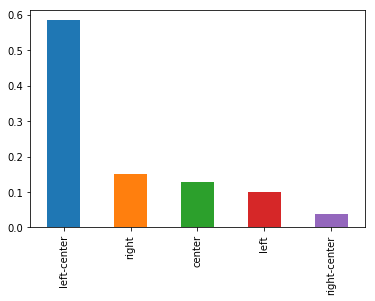

In [11]:
#distribution of different labels
df.label.value_counts(normalize = True).plot('bar')

In [12]:
#reindexing the dataframe to account for missing indices present in the dataframe
df = df.reindex(np.arange(df.index.min(), df.index.max() + 1))

In [13]:
#imporiting all libraries
# Run in python console
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rakeshravi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Convert to list
data = df.doc_content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[1837][0:2000])

('George W. Bush went home to Texas nearly six years ago, but the nation is '
 'still working through the contentious national security legacy he left '
 'behind.')


In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['washington', 'post', 'years', 'on', 'finding', 'profit', 'in', 'truth', 'on', 'jfk', 'caseabc', 'newson', 'the', 'very', 'day', 'john', 'kennedy', 'died', 'cottage', 'industry', 'was', 'born', 'fifty', 'years', 'and', 'hundreds', 'of', 'millions', 'of', 'dollars', 'later', 'its', 'still', 'thriving', 'its', 'product', 'the', 'truth', 'about', 'the', 'presidents', 'assassination', 'by', 'the', 'evening', 'of', 'november', 'found', 'myself', 'being', 'years', 'after', 'jfk', 'dallas', 'sheds', 'shadow', 'of', 'com', 'years', 'later', 'tv', 're', 'examines', 'kennedy', 'assassination', 'theoriessalt', 'lake', 'tribune', 'decades', 'later', 'some', 'jfk', 'probe', 'files', 'still', 'sealedlex', 'lexington', 'ky', 'newsall', 'news', 'articles']]


In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['washington', 'post', 'years', 'on', 'finding', 'profit', 'in', 'truth', 'on', 'jfk', 'caseabc', 'newson', 'the', 'very', 'day', 'john_kennedy', 'died', 'cottage_industry', 'was', 'born', 'fifty', 'years', 'and', 'hundreds', 'of', 'millions', 'of', 'dollars', 'later', 'its', 'still', 'thriving', 'its', 'product', 'the', 'truth', 'about', 'the', 'presidents', 'assassination', 'by', 'the', 'evening', 'of', 'november', 'found', 'myself', 'being', 'years', 'after', 'jfk', 'dallas', 'sheds', 'shadow', 'of', 'com', 'years', 'later', 'tv', 're', 'examines', 'kennedy_assassination', 'theoriessalt', 'lake', 'tribune', 'decades', 'later', 'some', 'jfk', 'probe', 'files', 'still', 'sealedlex', 'lexington_ky', 'newsall', 'news', 'articles']


In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['washington', 'post', 'year', 'find', 'profit', 'truth', 'jfk', 'caseabc', 'newson', 'day', 'kennedy', 'die', 'cottage_industry', 'bear', 'year', 'hundred', 'million', 'dollar', 'later', 'still', 'thrive', 'product', 'truth', 'president', 'assassination', 'evening', 'november', 'find', 'year', 'jfk', 'dalla', 'shed', 'shadow', 'com', 'year', 'later', 'tv', 'examine', 'kennedy', 'assassination', 'theoriessalt', 'lake', 'tribune', 'decade', 'later', 'jfk', 'probe', 'file', 'still', 'sealedlex', 'lexington_ky', 'newsall', 'news', 'article']]


In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 3), (17, 2), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 4)]]


In [21]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
lda_model.save('lda.model')

In [22]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"trump" + 0.022*"president" + 0.014*"say" + 0.011*"state" + '
  '0.011*"house" + 0.008*"would" + 0.006*"former" + 0.006*"democratic" + '
  '0.006*"washington" + 0.006*"donald"'),
 (1,
  '0.028*"say" + 0.017*"year" + 0.016*"reuter" + 0.013*"man" + 0.010*"new" + '
  '0.010*"police" + 0.008*"charge" + 0.008*"woman" + 0.008*"kill" + '
  '0.007*"authority"'),
 (2,
  '0.023*"news" + 0.011*"new" + 0.010*"coverage" + 0.008*"time" + '
  '0.007*"first" + 0.007*"get" + 0.007*"make" + 0.006*"not" + 0.006*"go" + '
  '0.006*"full_coverage"'),
 (3,
  '0.024*"second" + 0.017*"health" + 0.015*"story" + 0.013*"tech" + '
  '0.012*"coverage" + 0.012*"third" + 0.011*"price" + 0.011*"apple" + '
  '0.010*"link" + 0.009*"sale"')]


In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.78036026266503

Coherence Score:  0.42940940376333075


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.186403  0.025291       1        1  32.552753
2     -0.030582 -0.321630       2        1  31.901703
1     -0.179271  0.212932       3        1  30.362558
3      0.396256  0.083408       4        1   5.182990, topic_info=      Category           Freq           Term          Total  loglift  logprob
term                                                                         
5361   Default  111592.000000          trump  111592.000000  30.0000  30.0000
22     Default  112242.000000           news  112242.000000  29.0000  29.0000
27     Default  105196.000000      president  105196.000000  28.0000  28.0000
173    Default  193475.000000            say  193475.000000  27.0000  27.0000
76     Default   57232.000000       coverage   57232.000000  26.0000  26.0000
41     Default   92349.000000           year   92349.000000  25.0000  25.0000
285    Default   58291.000000            man   58291.000000  24.0000  24.0000
171    Default   84482.000000         reuter   84482.000000  23.0000  23.0000
244    Default   51220.000000          house   51220.000000  22.0000  22.0000
259    Default   18887.000000         second   18887.000000  21.0000  21.0000
2233   Default   45576.000000         police   45576.000000  20.0000  20.0000
65045  Default   32182.000000  full_coverage   32182.000000  19.0000  19.0000
829    Default   37422.000000         charge   37422.000000  18.0000  18.0000
53     Default   35250.000000           kill   35250.000000  17.0000  17.0000
4157   Default   22954.000000         google   22954.000000  16.0000  16.0000
176    Default   81915.000000          state   81915.000000  15.0000  15.0000
121    Default   34646.000000            get   34646.000000  14.0000  14.0000
240    Default   13342.000000         health   13342.000000  13.0000  13.0000
105    Default   36650.000000          woman   36650.000000  12.0000  12.0000
268    Default   32156.000000      authority   32156.000000  11.0000  11.0000
132    Default   31733.000000            old   31733.000000  10.0000  10.0000
300    Default   39421.000000           time   39421.000000   9.0000   9.0000
1095   Default   11919.000000          story   11919.000000   8.0000   8.0000
402    Default   30990.000000     democratic   30990.000000   7.0000   7.0000
188    Default   28972.000000           city   28972.000000   6.0000   6.0000
677    Default   29615.000000            not   29615.000000   5.0000   5.0000
455    Default   43861.000000          would   43861.000000   4.0000   4.0000
1258   Default   17836.000000        company   17836.000000   3.0000   3.0000
2154   Default   29096.000000         donald   29096.000000   2.0000   2.0000
81     Default   28606.000000       election   28606.000000   1.0000   1.0000
...        ...            ...            ...            ...      ...      ...
12894   Topic4    3732.491455        android    3733.317627   2.9596  -5.3317
691     Topic4    3735.893555            inc    3736.738525   2.9596  -5.3308
1312    Topic4    3135.658203       investor    3136.496094   2.9595  -5.5059
3562    Topic4    3233.322266          surge    3234.213135   2.9595  -5.4752
15710   Topic4    3092.318848     venezuelan    3093.174805   2.9595  -5.5198
5330    Topic4    2810.336914           user    2811.175293   2.9595  -5.6154
8292    Topic4    2712.615967         iphone    2713.440918   2.9595  -5.6508
4091    Topic4    2773.297119       purchase    2774.168701   2.9595  -5.6287
34814   Topic4    2525.430908          measl    2526.260010   2.9595  -5.7223
899     Topic4    2838.783447         column    2839.718262   2.9595  -5.6054
5040    Topic4    2595.430664       collapse    2596.306396   2.9595  -5.6950
834     Topic4    2476.250977       consumer    2477.098877   2.9594  -5.7420
11485   Topic4    2629.517578      netanyahu    2630.925293   2.9593  -5.6819
3818    Topic4    3428.197998         device 

In [ ]:
df["topic0"] = 0
df["topic1"] = 0
df["topic2"] = 0
df["topic3"] = 0
printcounter = 0
for index,row in df.iterrows():
    if (printcounter == 1000000):
        print(printcounter)
        printcounter = 0
    try:
        mod_output = lda_model[corpus[index]][0]
    except IndexError:
        break
    for (topic,prob) in mod_output:
        df.loc[index,'topic' + str(topic)] = prob
    printcounter += 1

In [34]:
df.to_csv("/Users/rakeshravi/Documents/Spring/Text Analytics/Project/corpus_plus_topics.csv")